In [2]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import glob
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sunpy.coordinates.sun as sn
import scipy.ndimage as ndi
import scipy.stats as st
# Our own library for using spice with STEREO (https://github.com/LukeBarnard/stereo_spice)
from stereo_spice.coordinates import StereoSpice
# Local packages
import HUXt as H

spice = StereoSpice()


In [ ]:
def setup_huxt(start_time, uniform_wind=True):
    """
    Initialise HUXt with some predetermined boundary/initial conditions
    start_time should be astropy.Time object.
    wind should be uniform or structured
    """
    cr_num = np.fix(sn.carrington_rotation_number(start_time))
    ert = H.Observer('EARTH', start_time)

    # Set up HUXt for a 5 day simulation with homogenous inner boundary.
    vr_in, br_in = H.Hin.get_MAS_long_profile(cr_num, ert.lat.to(u.deg))
    if uniform_wind:
        vr_in = np.zeros(vr_in.shape) + 400*vr_in.unit
        
    model = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
                   br_boundary=br_in, lon_start=270*u.deg, lon_stop=90*u.deg, simtime=3.5*u.day, dt_scale=4)
    
    return model

def get_base_cme(v=1000, lon=0, lat=0, width=45, thickness=5):
    """
    Return the base CME, which is used to establish the pseudo-truth CME and the SIR ensemble
    """
    t_launch = (1*u.hr).to(u.s)
    cme = H.ConeCME(t_launch=t_launch, longitude=lon*u.deg, latitude=lat*u.deg, width=width*u.deg, v=v*(u.km/u.s), thickness=thickness*u.solRad)
    return cme

def perturb_cone_cme(cme):
    """
    Perturb a ConeCME's parameters. Used to establish the pseudo-truth CME and the initial SIR ensemble members. 
    """
    lon_new = perturb_cme_param(cme.longitude, 5*u.deg)
    lat_new = perturb_cme_param(cme.latitude, 5*u.deg)
    width_new = perturb_cme_param(cme.width, 5*u.deg)
    speed_new = perturb_cme_param(cme.v, 50*u.km/u.s)
    thickness_new = perturb_cme_param(cme.thickness, 1*u.solRad)

    cme_perturb = H.ConeCME(t_launch=cme.t_launch,
                            longitude=lon_new,
                            latitude=lat_new,
                            width=width_new,
                            v=speed_new,
                            thickness=thickness_new)
    return cme_perturb

def perturb_cme_param(param, spread):
    """
    Randomly perturb a CME paramter with the uniform distribution and a specified spread
    """
    param_new = param + np.random.uniform(-1, 1, 1)[0] * spread
    return param_new

def compute_observed_cme_profile(observer_lon, cme, dt_scale=5, el_max=30):
    """
    Compute the time-elongation profile of a specified observer.
    Observer longitude is relative to Earth.
    """
    
    # Compute the time-elongation profiles of the CME flanks from STA and STB
    coords = compute_t_e_profile(observer_lon, cme)

    # Remove invalid points
    coords.dropna(inplace=True)

    # Add observation noise.
    obs = coords.loc[:, ['time', 'el']].copy()
    obs['el'] = obs['el'] + 0.5*np.random.randn(obs.shape[0])

    # Only keep every dt_scale'th observation and reindex - dt_scale=5 corrsponds to ~2hr
    obs = obs[::dt_scale]
    obs.set_index(np.arange(0, obs.shape[0]), inplace=True)

    # Only analyse up to 30 deg elon ~ approx the HI1 FOV
    id_fov = obs['el'] <= el_max
    obs = obs[id_fov]
    return obs
    
def compute_t_e_profile(observer_lon, cme):
    """
    Compute the time elongation profile of the flank of a ConeCME in HUXt. The observer longtidue is specified relative to Earth,
    and but otherwise matches Earth's coords. 

    Parameters
    ----------
    observer_lon: Angular separation of Earth and the observer, in HEEQ.
    cme: A ConeCME object from a completed HUXt run (i.e the ConeCME.coords dictionary has been populated).
    Returns
    -------
    obs_profile: Pandas dataframe giving the coordinates of the ConeCME flank from STA's perspective, including the
                time, elongation, position angle, and HEEQ radius and longitude.
    """
    times = Time([coord['time'] for i, coord in cme.coords.items()])
    
    # Compute observers location using earth ephem, adding on observers longitude offset from Earth and correct for runover 2*pi
    obs = H.Observer('EARTH', times)
    obs.lon = obs.lon + observer_lon
    id_over = obs.lon > 2*np.pi*u.rad
    if np.any(id_over):
        obs.lon[id_over] = obs.lon[id_over] - 2*np.pi*u.rad
    
    obs_profile = pd.DataFrame(index=np.arange(times.size), columns=['time', 'el', 'r', 'lon'])
    obs_profile['time'] = times.jd
    
    for i, coord in cme.coords.items():

        if len(coord['r']) == 0:
            obs_profile.loc[i, ['lon','r', 'el']] = np.NaN
            continue

        r_obs = obs.r[i]
        x_obs = obs.r[i] * np.cos(obs.lat[i]) * np.cos(obs.lon[i])
        y_obs = obs.r[i] * np.cos(obs.lat[i]) * np.sin(obs.lon[i])
        z_obs = obs.r[i] * np.sin(obs.lat[i])

        lon_cme = coord['lon']
        lat_cme = coord['lat']
        r_cme = coord['r']

        x_cme = r_cme * np.cos(lat_cme) * np.cos(lon_cme)
        y_cme = r_cme * np.cos(lat_cme) * np.sin(lon_cme)
        z_cme = r_cme * np.sin(lat_cme)
        #############
        # Compute the observer CME distance, S, and elongation

        x_cme_s = x_cme - x_obs
        y_cme_s = y_cme - y_obs
        z_cme_s = z_cme - z_obs
        s = np.sqrt(x_cme_s**2 + y_cme_s**2 + z_cme_s**2)

        numer = (r_obs**2 + s**2 - r_cme**2).value
        denom = (2.0 * r_obs * s).value
        e_obs = np.arccos(numer / denom)

        # Find the flank coordinate and update output
        id_obs_flank = np.argmax(e_obs)       
        obs_profile.loc[i, 'lon'] = lon_cme[id_obs_flank].value
        obs_profile.loc[i, 'r'] = r_cme[id_obs_flank].value
        obs_profile.loc[i, 'el'] = np.rad2deg(e_obs[id_obs_flank])
    
    # Force values to be floats.
    keys = ['lon', 'r', 'el']
    obs_profile[keys] = obs_profile[keys].astype(np.float64)
    return obs_profile

def compute_observation_likelihood(t_obs, e_obs, profile):
    """
    Compute the likelihood of an observed elongation measurement for a modelled elongation measurement.
    Assumes a gaussian likelihood centered on the modelled elongation.
    """
    
    # Find the modelled elon at observation time
    e_mod = profile.loc[profile['time'] == t_obs, 'el'].values[0]
    # Compute likelihood of the observation.
    if np.isnan(e_mod):
        lkhd = np.NaN
    else:
        lkhd = st.norm.pdf(e_obs, loc=e_mod, scale=0.5)
        
    return lkhd

def get_cme_params_for_sir(cme):
    """
    Form an array of the CME parameter values that are kept track of in the ensemble members.
    """
    params = np.array([cme.t_launch.to('s').value, cme.longitude.to('rad').value, cme.latitude.to('rad').value,
                          cme.width.to('rad').value, cme.v.value, cme.thickness.to('km').value])
    
    return params

def create_analysis_output_file(filename):
    """
    Create a HDF5 file for storing the SIR analysis steps.
    """
    proj_dirs = H._setup_dirs_()
    out_filepath = os.path.join(proj_dirs['out_data'], filename)
    if os.path.isfile(out_filepath):
        # File exists, so delete and start new.
        print("Warning: {} already exists. Overwriting".format(out_filepath))
        os.remove(out_filepath)

    out_file = h5py.File(out_filepath, 'w')
    return out_file

def cme_kde_resample_with_weights(cme_prior, weights):
    """
    Use kernel density estimation to resample particles from the prior distriubtion given the particle weights.
    """
    # Find valid weights, and pull out each corresponding particles parameters
    n_ensemble = len(weights)
    valid_weights = np.isfinite(weights)
    weights = weights[valid_weights]
    lon = cme_prior[valid_weights, 1].squeeze()
    lat = cme_prior[valid_weights, 2].squeeze()
    width = cme_prior[valid_weights, 3].squeeze()
    v = cme_prior[valid_weights, 4].squeeze()
    thick = cme_prior[valid_weights, 5].squeeze()
    
    # Force lon so no disconinuity at 2pi
    lon[lon>=np.pi] += -2*np.pi

    # KDE fit each distribution, draw random sample. 
    cme_update = np.zeros(cme_prior.shape)*np.NaN
    cme_update[:, 0] = cme_prior[:, 0].copy()
    
    col_id = [1,2,3,4,5]
    param = [lon, lat, width, v, thick]
    for col, p in zip(col_id, param):
        kde = st.gaussian_kde(p, bw_method='silverman',  weights=weights)
        sample = kde.resample(n_ensemble)
        cme_update[:, col] = sample.copy()
        
    # Put lon back on 0-2pi domain
    id_low = cme_update[:, 1] < 0
    cme_update[id_low, 1] += 2*np.pi
    
    return cme_update


def update_ensemble_conecmes(cme_params):
    """
    Produce the list of updated conecmes.
    """
    conecme_update = []
    for i in range(cme_params.shape[0]):
        conecme = H.ConeCME(t_launch=cme_params[i, 0]*u.s,
                            longitude=cme_params[i, 1]*u.rad,
                            latitude=cme_params[i, 2]*u.rad,
                            width=cme_params[i, 3]*u.rad,
                            v=cme_params[i, 4]*(u.km/u.s),
                            thickness=(cme_params[i, 5]*u.km).to(u.solRad))
        conecme_update.append(conecme)
        
    return conecme_update

In [ ]:
# Start up HUXt at a specified time.
np.random.seed(192938)
n_ensemble = 50
obs_lon = -60*u.deg

start_time = Time('2008-01-01T00:00:00')
model = setup_huxt(start_time)

# Initialise Earth directed CME. Coords in HEEQ, so need Earth Lat.
ert = model.get_observer('EARTH')
avg_ert_lat = np.mean(ert.lat.to(u.deg).value)
cme_base = get_base_cme(v=1000, lon=0, lat=avg_ert_lat, width=45)

# Perturb the base CME to get a "pseudo-truth", and solve
cme_truth = perturb_cone_cme(cme_base)
model.solve([cme_truth])
cme_truth = model.cmes[0]
truth_profile = compute_t_e_profile(obs_lon, cme_truth)

obs_profile = compute_observed_cme_profile(obs_lon, cme_truth, dt_scale=5, el_max=30.0)
if obs_lon.value < 0:
    obs_lon_out = np.int(np.fix(obs_lon.value + 360.0))
    
# Compute estimate of observations (with some noise included)
for iii in range(30):

    filename = "SIR_HUXt_analysis_{:02d}.hdf5".format(iii)
    out_file = h5py.File(filename, 'w')
    out_file.create_dataset('obs_lon', data=obs_lon.value)
    out_file.create_dataset('n_ensemble', data=n_ensemble)
    out_file.create_dataset('truth_profile', data=truth_profile.values)
    out_file.create_dataset('obs_profile', data=obs_profile.values)
    out_file.create_dataset('truth_arrival', data=cme_truth.earth_arrival_time.jd)

    #Loop through the obs and do the SIR
    for i, row in obs_profile.iterrows():
        t_obs = row[0]
        e_obs = row[1]

        arrival_arr = np.zeros((n_ensemble))*np.NaN
        lkhd_arr = np.zeros((n_ensemble))*np.NaN
        all_cme_params = np.zeros((n_ensemble, 6))*np.NaN

        for j in range(n_ensemble):

            if i == 0:
                cme_ens = perturb_cone_cme(cme_base)
            else:
                cme_ens = next_cone_cmes[j]

            # Solve huxt with the perturbed CME
            model.solve([cme_ens])
            cme_ens = model.cmes[0]          

            # Stash this CMEs parameters and arrival time
            arrival_arr[j] = cme_ens.earth_arrival_time.jd
            all_cme_params[j,:] = get_cme_params_for_sir(cme_ens)

            # Get the time elon profile 
            model_profile = compute_t_e_profile(obs_lon, cme_ens)
            # Compute the likelihood of the obs
            lkhd_arr[j] = compute_observation_likelihood(t_obs, e_obs, model_profile)

            # Append profile to all ensemble profiles
            if j == 0:
                all_profiles = model_profile.loc[:,['time', 'el']].copy()
                all_profiles.rename(columns={"el": "el_{:02d}".format(j)}, inplace=True)
            else:
                all_profiles['el_{:02d}'.format(j)] = model_profile['el']

        # Now compute the member weights
        weights = lkhd_arr / np.nansum(lkhd_arr)
        # Resample the CMEs and get updated list of Cone CMEs
        next_cme_params = cme_kde_resample_with_weights(all_cme_params, weights)
        next_cone_cmes = update_ensemble_conecmes(next_cme_params)

        # Save the data
        analysisgrp = out_file.create_group('analysis_{:02d}'.format(i))
        analysisgrp.create_dataset('t_obs', data=t_obs)
        analysisgrp.create_dataset('el_obs', data=e_obs)
        analysisgrp.create_dataset('cme_params', data=all_cme_params)
        analysisgrp.create_dataset('ensemble_profiles', data=all_profiles.values)
        analysisgrp.create_dataset('likelihood', data=lkhd_arr)
        analysisgrp.create_dataset('weights', data=weights)
        analysisgrp.create_dataset('arrivals', data=arrival_arr)
        out_file.flush()

    out_file.close()


0.4888203145137855 -0.1389622235936778
0.6284306698792905 0.6857672901733471
0.9163905582612971


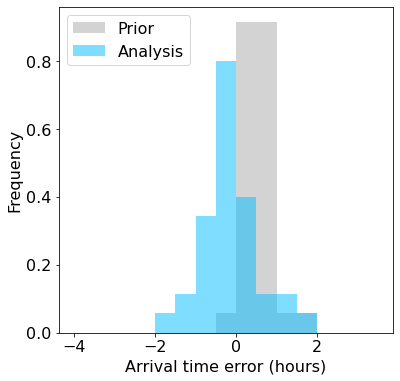

In [32]:
out_files = glob.glob('SIR_HUXt_analysis_*.hdf5')

arrival_ens = []
arrival_sir = []
arrival_tru = []

for i, filename in enumerate(out_files):
    
    out_file = h5py.File(filename, 'r')
    
    arrival_tru.append(out_file["truth_arrival"][()])

    analysis_keys = []
    for k in out_file.keys():
        if k.split("_")[0] =='analysis':
            analysis_keys.append(k)

    arr = out_file[analysis_keys[0] + "/arrivals"][()]
    arr[arr==1721059.5] = np.NaN
    id_good = np.isfinite(arr)
    arr = arr[id_good]
    arrival_ens.append(np.mean(arr))
    
    arr = out_file[analysis_keys[-1] + "/arrivals"][()]
    weight = out_file[analysis_keys[-1] + "/weights"][()]
    arr[arr==1721059.5] = np.NaN
    id_good = np.isfinite(arr)
    arr = arr[id_good]
    weight = weight[id_good]
    arrival_sir.append(np.average(arr, weights=weight))
    out_file.close()
    
arrival_ens = Time(np.array(arrival_ens),format='jd')
arrival_sir = Time(np.array(arrival_sir), format='jd')
arrival_tru = Time(np.array(arrival_tru), format='jd')

ens_err = (arrival_ens - arrival_tru).jd*24
ens_rmse = np.sqrt(np.mean(ens_err**2))
sir_err = (arrival_sir - arrival_tru).jd*24
sir_rmse = np.sqrt(np.mean(sir_err**2))


print(np.mean(ens_err), np.mean(sir_err))
print(ens_rmse, sir_rmse)
print(ens_rmse/sir_rmse)

bins = np.arange(-4, 4, 0.5)
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(ens_err, bins, density=True, color='lightgrey', label='Prior', alpha=1.0)
ax.hist(sir_err, bins, density=True, color='deepskyblue', alpha=0.5, label='Analysis')
ax.set_xlabel('Arrival time error (hours)')
ax.set_ylabel('Frequency')
ax.legend()

[20.5, 25.0, 25.0, 33.0, 25.5, 26.5, 28.0, 26.0, 23.5, 23.5, 24.0, 26.0, 25.0, 25.5, 27.0, 20.5, 26.0, 30.0, 26.5, 31.0, 30.5, 29.5, 28.0, 27.5, 27.5, 28.5, 29.0, 28.0, 28.0, 30.5, 20.0, 33.0, 28.0, 27.5, 29.0] [27.0, 27.0, 24.0, 24.5, 14.0, 17.0, 21.0, 23.0, 22.0, 17.0, 22.0, 28.5, 16.0, 19.0, 19.5, 24.0, 25.0, 14.5, 16.0, 30.0, 17.0, 26.0, 21.5, 23.5, 16.0, 24.0, 33.0, 21.0, 11.0, 20.0, 18.5, 22.5, 27.5, 22.0, 31.0]


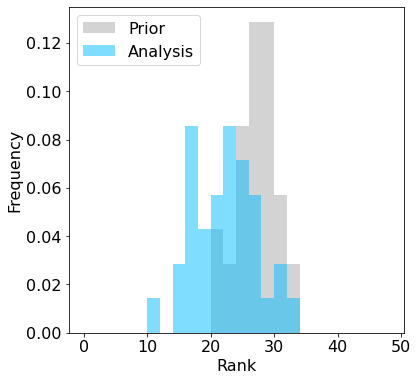

In [39]:
out_files = glob.glob('SIR_HUXt_analysis_*.hdf5')

rank_ens = []
rank_sir = []

for i, filename in enumerate(out_files):
    
    out_file = h5py.File(filename, 'r')
    
    arrival_tru = out_file["truth_arrival"][()]

    analysis_keys = []
    for k in out_file.keys():
        if k.split("_")[0] =='analysis':
            analysis_keys.append(k)

    arr_prior = out_file[analysis_keys[0] + "/arrivals"][()]
    arr_prior = np.append(arr_prior, arrival_tru)
    ranks = st.rankdata(arr_prior)
    rank_ens.append(ranks[-1])
    
    
    arr = out_file[analysis_keys[-1] + "/arrivals"][()]
    arr[arr==1721059.5] = np.NaN
    id_good = np.isfinite(arr)
    arr = arr[id_good]
    
    arr = np.append(arr, arrival_tru)
    ranks = st.rankdata(arr)
    rank_sir.append(ranks[-1])
    out_file.close()
    
print(rank_ens, rank_sir)

bins = np.arange(0, 50, 2)
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(rank_ens, bins, density=True, color='lightgrey', label='Prior', alpha=1.0)
ax.hist(rank_sir, bins, density=True, color='deepskyblue', alpha=0.5, label='Analysis')
ax.set_xlabel('Rank')
ax.set_ylabel('Frequency')
ax.legend()